In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import math
import numpy as np
# Loading your IBM Q account(s)
#provider = IBMQ.load_account()
#need to everything in one circuit for it to plot

## Initialisation 


In [2]:
#data and templates are all in binary form and we compare bit by bit
#define data register. Completely arbitrary, n is the number of qubits 
n=3
nanc=1
a=n+nanc
#precision digits =3
p=5

### creating the quantum registers

In [3]:
#to store the right templates
data = QuantumRegister(n,'data')
#the registers used to check, the last qubit is the ancilla
templates=QuantumRegister(a,'templates')
#the classical register to store the results
result=ClassicalRegister(p,'result')
#the counting register
counting=QuantumRegister(p,'counting')
#make the counting register in superposition
search_Circuit=QuantumCircuit(data,templates,counting,result)

In [4]:
#data is 0011 
search_Circuit.x(data[1])
search_Circuit.x(data[2])
#search_Circuit.h(data[0])

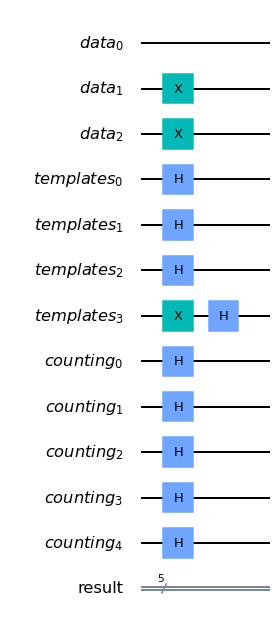

In [5]:
#search qubits are initialised to 0 while the ancilla is initialised to 1
search_Circuit.x(templates[n])
#Hadmard gate is applied to all qubits
search_Circuit.h(templates[0:a]) 
#counting qubits are initilised to + as well
search_Circuit.h(counting) 
#search_Circuit.x(counting[0]) 
#search_Circuit.x(counting[1]) 
search_Circuit.draw(output="mpl")

## Creating Grover's gate 

In [6]:
#unfortunately qiskit does not have ccccx gate so we have to define
#This is good because we dont have to put in number of qubits by hand
from qiskit.circuit.library.standard_gates import XGate,ZGate
def controlx(n):
    cx_gate = XGate().control(n)
    return cx_gate
def controlz(n):
    cz_gate = ZGate().control(n)
    return cz_gate

### Creating the Oracle function

In [7]:
#templace matching oracle
#data bit match with template bit
#cx: is a classical AND gate, the result is on the second qubit.  ,templates,data
def template_matching_oracle(qc,ndata):
    '''
    inputregister is the superposition of templates 
    data is what we are comparing with
    we are comparing bit by bit, and only when all the comparison is positive we should have 1 in the result register
    #qubits = circuit.qubits
    #cr=ClassicalRegister(nqubits)
    #the two registers should have the same number of qubits
    '''
    qubits=qc.qubits
    #nqubits = len(templates)-1
    #qc=QuantumCircuit(templates,data)
    for qubit in range(ndata):
        #comparing data with templates qubit by qubit, first is the controll bit
        qc.cx(qubit, qubit+ndata)
        #cx gives a 0 if they match. so x-gates are needed 
        qc.x(qubit+ndata)
    '''
    now is the magic: ancilla qubit which is in the |-> state, with a cccc-x, would if and only if
    adopt a - sign when all bits match
    shame here need to manually change how many control with regard to how many qubits in the template register
    '''
    #qcmin=QuantumCircuit(templates)
    #unfortunately we need to hardcode the control gate in
    cx_gate=controlx(ndata)
    qc.append(cx_gate,[ndata]+[*range(ndata+1,ndata+n+1)])
    #qc.ccccx(templates[0:nqubits],ancilla)
    #reverse the previous processes to restore the template register
    for qubit in range(ndata):
        qc.x(qubit+ndata)
        qc.cx(qubit, qubit+ndata)
    #reverse the ancilla bit
    #qc.h(2*ndata)
    #return (qc)
        

In [8]:
#test oracle
'''
oracle_circuit=QuantumCircuit(templates,data)
oracle_circuit=template_matching_oracle(templates,data)
oracle_circuit.draw(output='mpl')
template_matching_oracle(search_Circuit,n)
search_Circuit.draw(output="mpl")'''

'\noracle_circuit=QuantumCircuit(templates,data)\noracle_circuit=template_matching_oracle(templates,data)\noracle_circuit.draw(output=\'mpl\')\ntemplate_matching_oracle(search_Circuit,n)\nsearch_Circuit.draw(output="mpl")'

### Creating the Diffusion operator function

2|ψihψ| −IN = H
⊗n
(2|0ih0| −IN)H
⊗n
,
where |ψi is the uniform superposition of states and IN is
the N dimensional identity matrix. As 2|ψihψ| −IN operates
a reflection about the |ψi, 2|0ih0| − IN operates a reflection
about the |0i. It turns out that Grover diffusion can be implemented on a quantum circuit with a phase shift operator that
negates all the states except for |0i sandwiched between H
⊗n
gates (see Section III for the implementation). More detailed
explanations can be found in Nielsen and Chuang [17].

In [9]:
#diffusion operator
def DiffOpe(qc,ndata):
    #nqubit = len(templates)-1
    #qc=QuantumCircuit(templates)
    #the hadmard  
    controlqubits=ndata-1
    cz_gate=controlz(controlqubits)
    for qubit in range(ndata):
        qc.h(ndata+qubit)
        qc.x(ndata+qubit)
    #the phase change, again, we need to hardcode it now
    qc.append(cz_gate,[ndata]+[*range(ndata+1,ndata+n)])
    #reverse the process to restore the register
    for qubit in range(ndata):
        qc.x(ndata+qubit)
        qc.h(ndata+qubit)

    #return (qc)
        
    


## Quantum phase estimation
Estimate the number of repetitions needed for multiple matches

### Controlled Grover's Gate
We can use .to_gate() and .control() to create a controlled gate from a circuit. We will call our Grover iterator grit and the controlled Grover iterator cgrit
All those controlled gate functions in qiskit is difficult for this situation because they apply to gates, but our grovers operation is only a function. So either we can rewrite this as a gate or we define our controlled funcion, which I chose the latter. And because it is controlled by qubits one by one in the counting register it is possible to write

In [10]:
#making Grover's algorithm into a gate
def GroverGate(qc,ndata):
    template_matching_oracle(qc,ndata)
    DiffOpe(qc,ndata)
    return qc

In [11]:
GateCircuit=QuantumCircuit(data,templates)
GateCircuit=GroverGate(GateCircuit,n)
#GateCicuit.draw(output="mpl")  
#C_Grover = GateCircuit.to_gate().control()
#print (C_Grover.num_qubits)
G_Grover = GateCircuit.to_gate()
G_Grover.label = "GroverGate"
C_Grover = G_Grover.control()
#cgrit.label = "Grover"
#list(range(1,9))

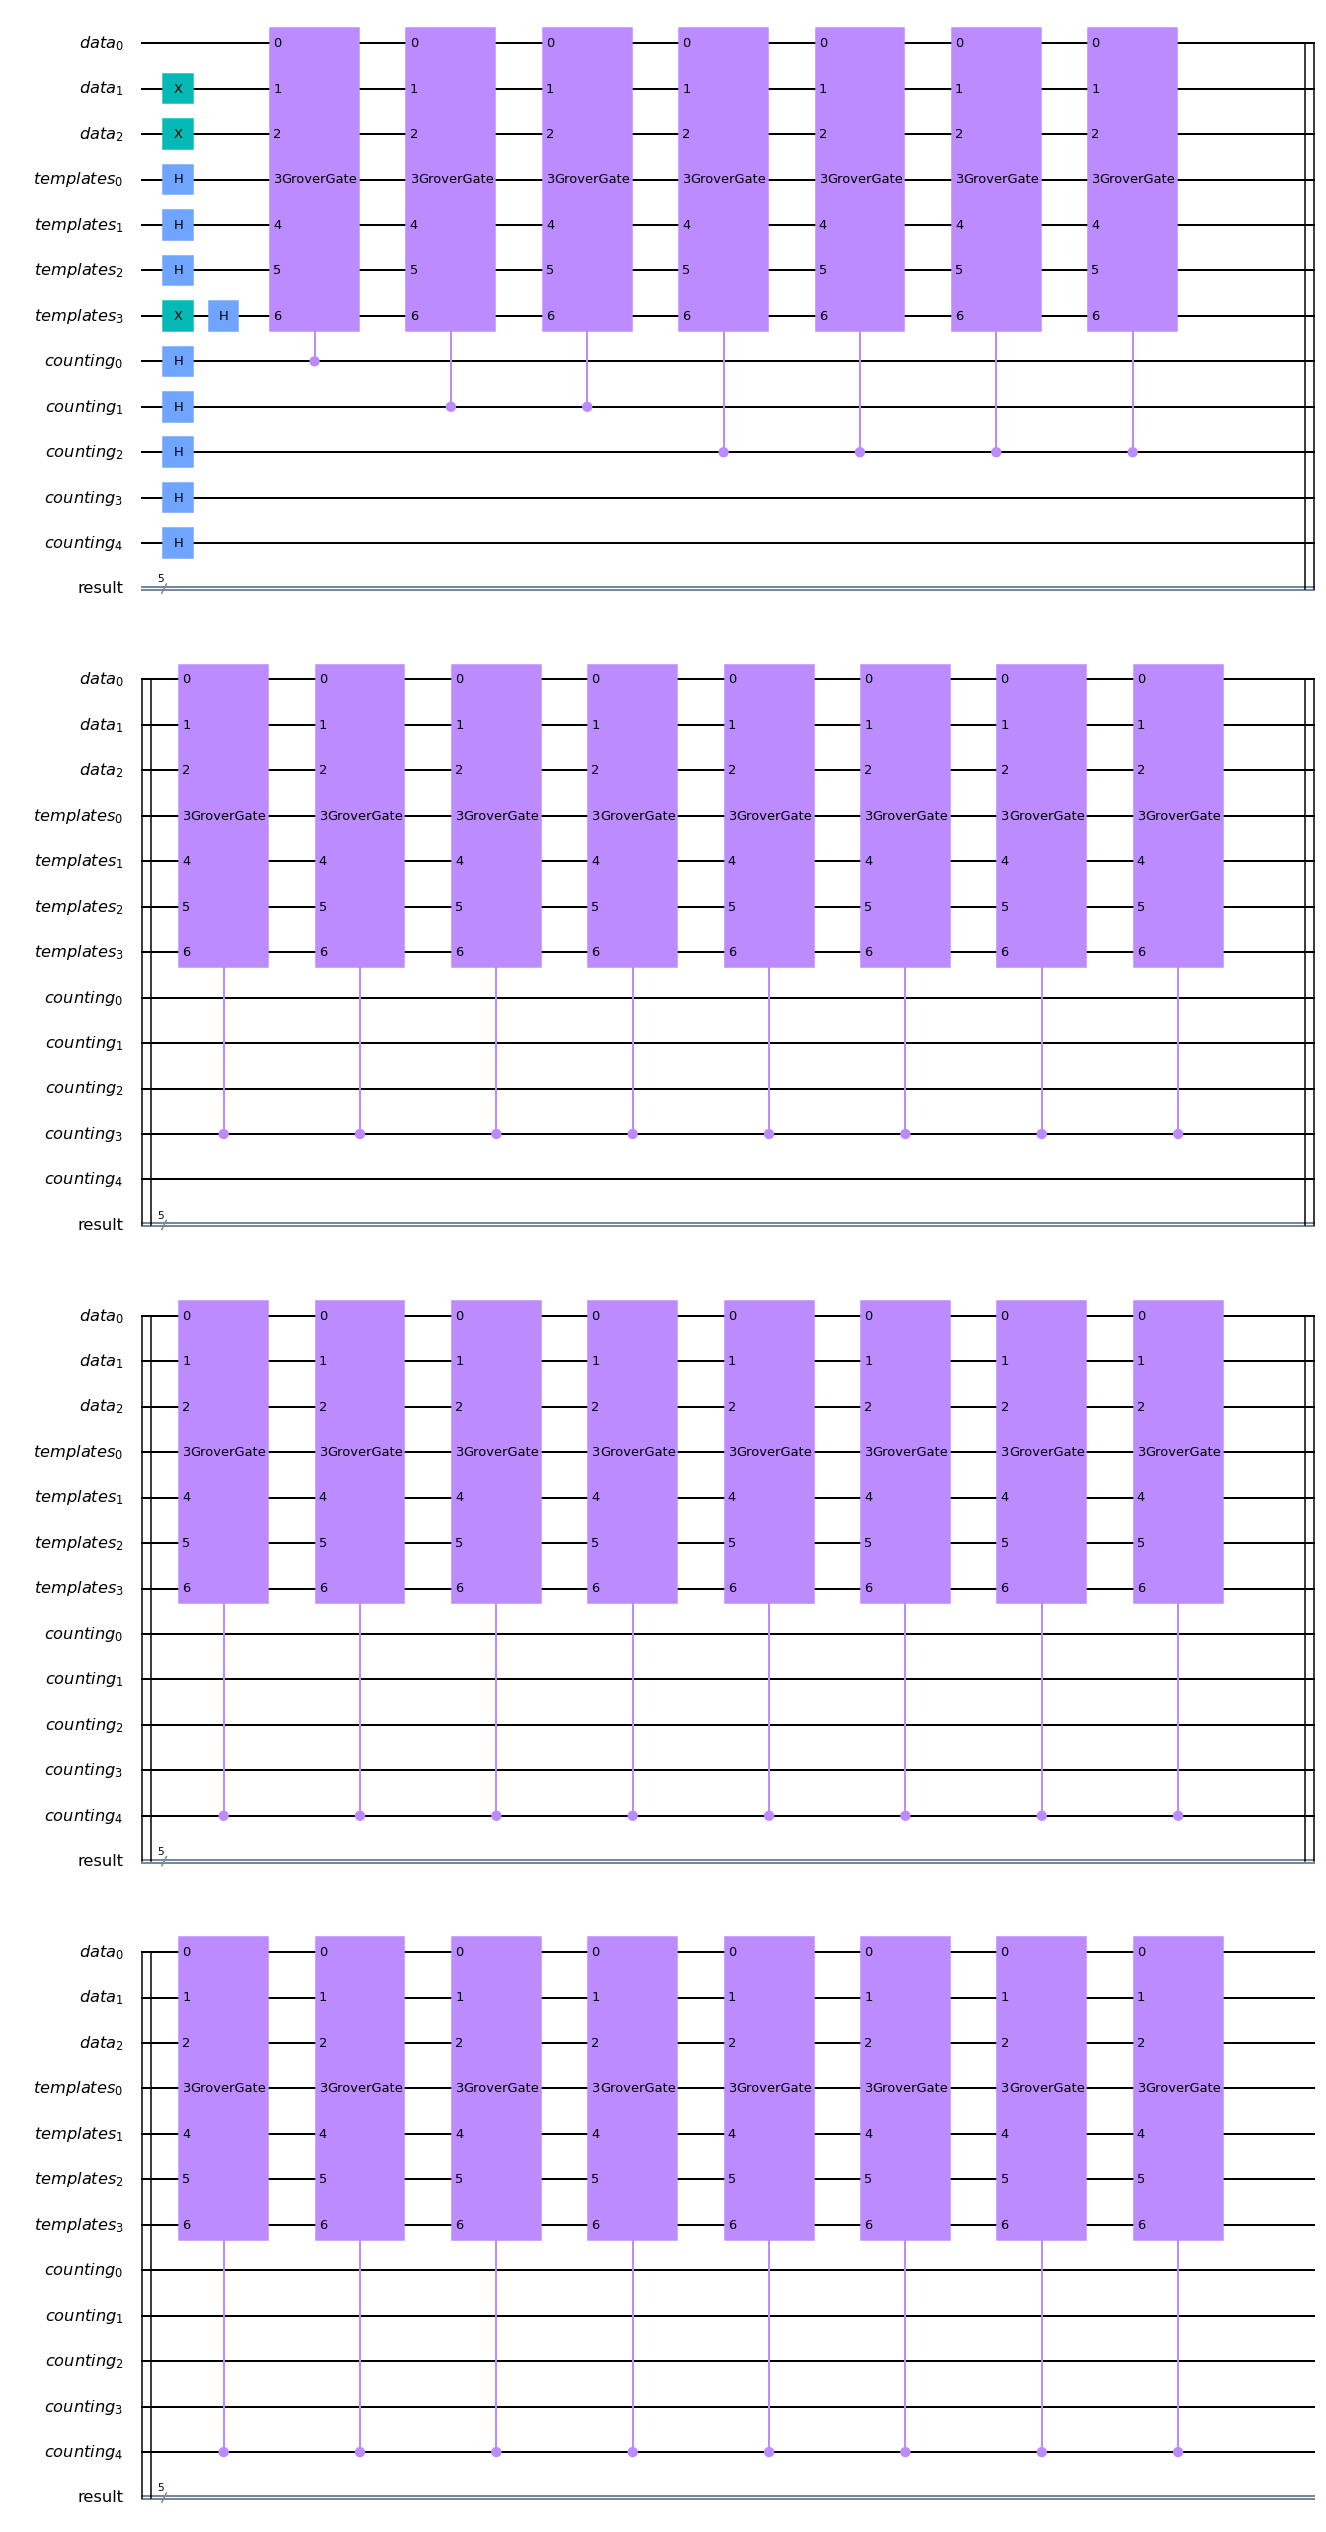

In [12]:
#the controlled Grover gate part in QPE
iteration=1
#looping through all the counting qubits
for countingqubit in np.arange(n+a,n+a+p):
    for i in np.arange(iteration):
        #this loop is to apply grovers 2^p times
        search_Circuit.append(C_Grover, [countingqubit]+[*range(0,n+a)])
    iteration *=2
search_Circuit.draw(output="mpl")

In [13]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cu1(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

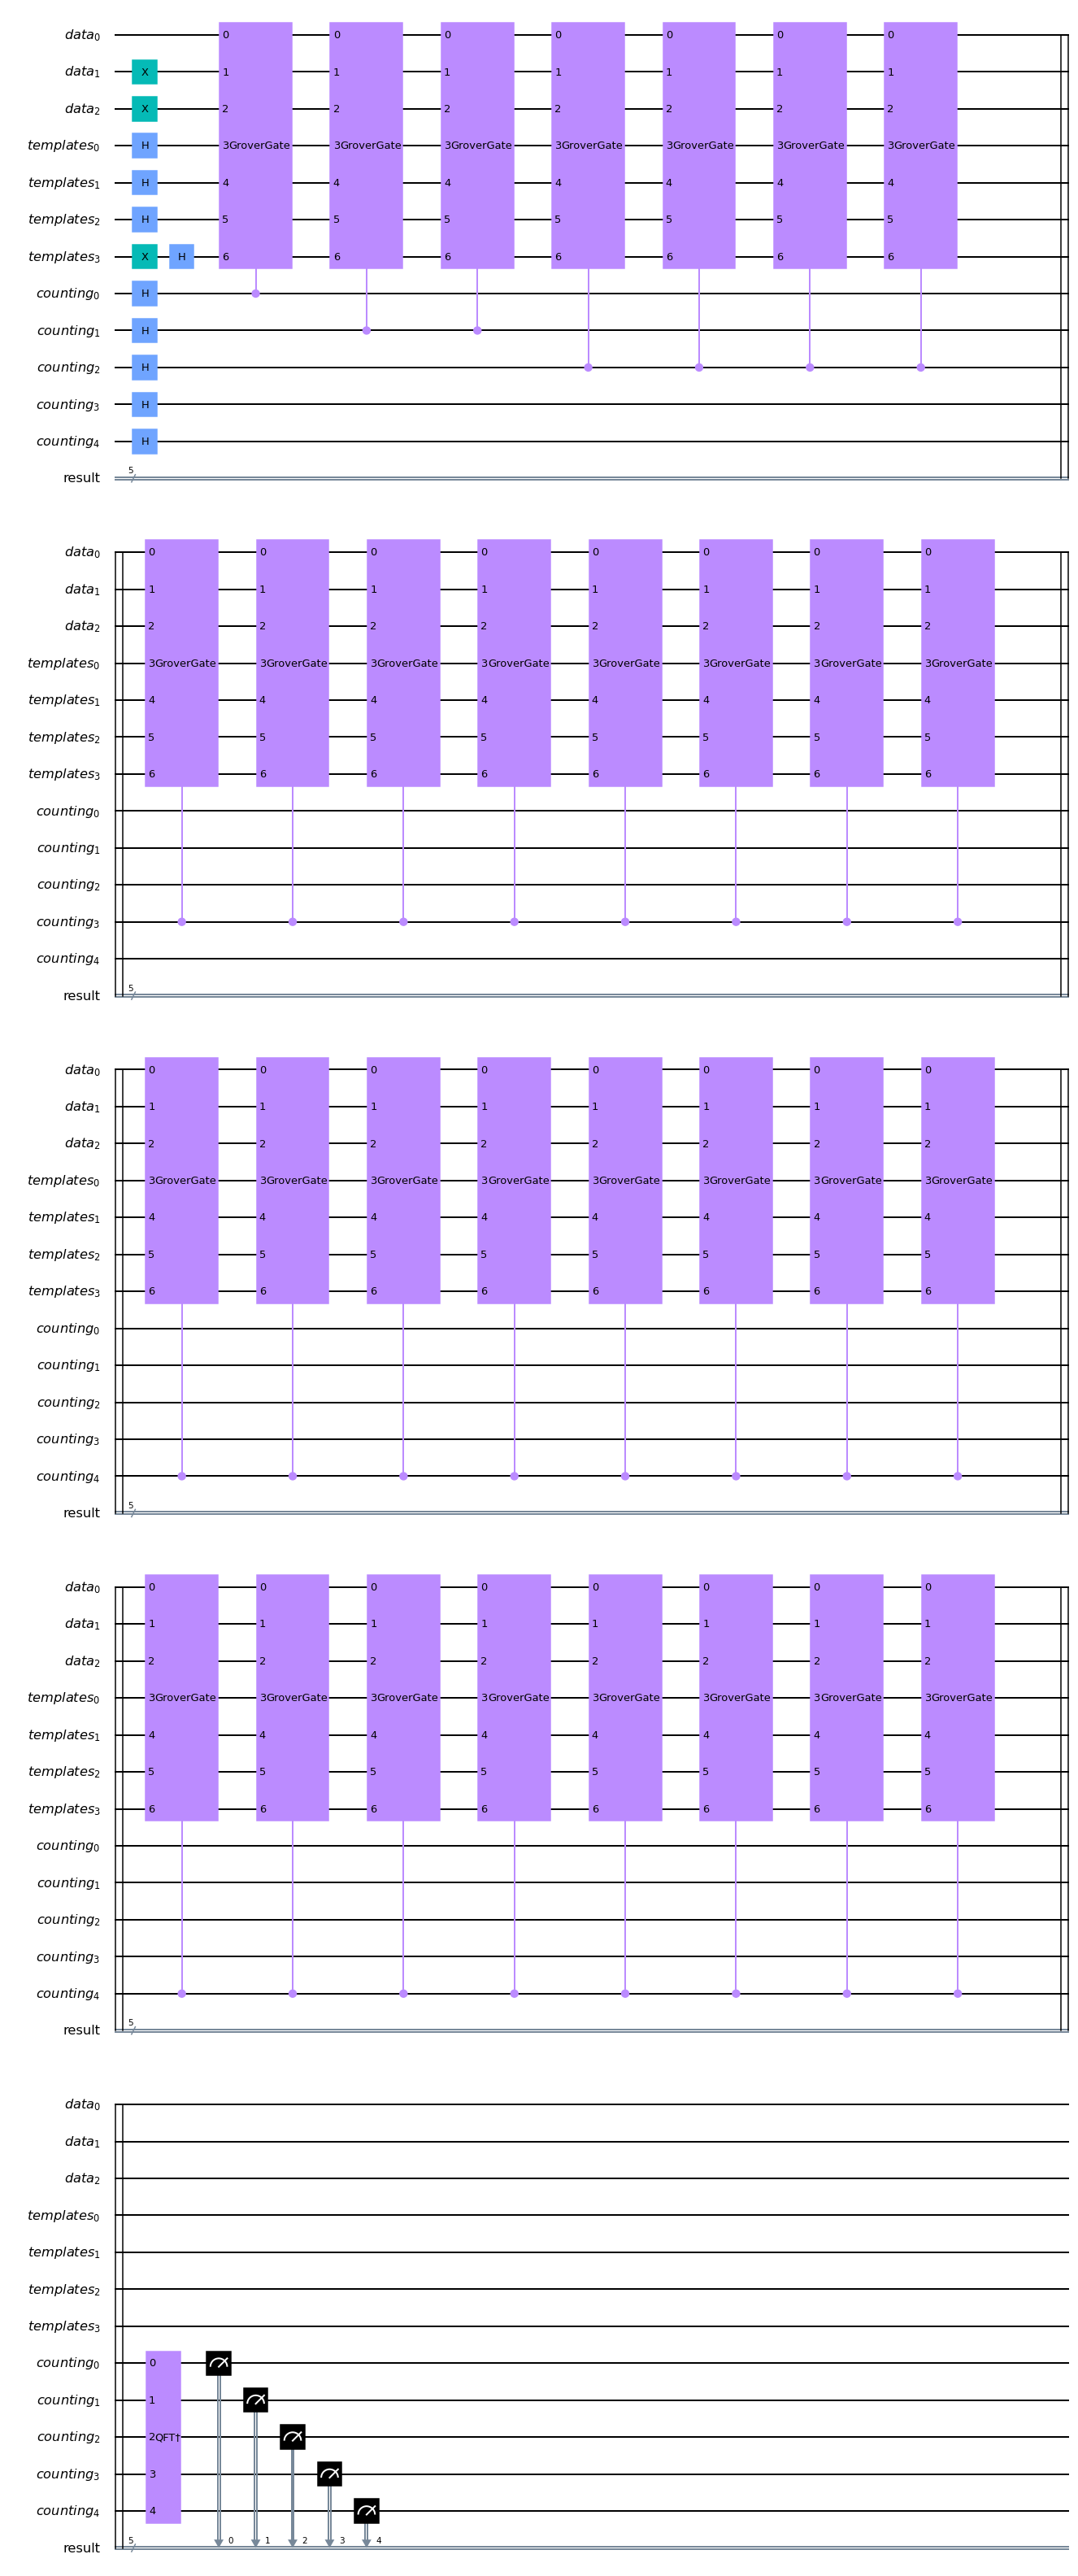

In [14]:
#measuring the counting qubits and output k_t
qft_dagger = qft(p).to_gate().inverse()
qft_dagger.label = "QFT†"
# Do inverse QFT on counting qubits
search_Circuit.append(qft_dagger, list(range(n+a,n+a+p)))
# Measure counting qubits
search_Circuit.measure(list(range(n+a,n+a+p)), result[list(range(p))])
search_Circuit.draw(output="mpl")


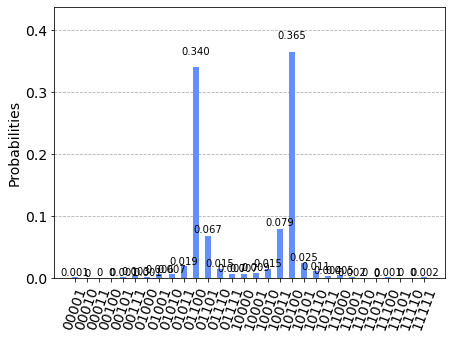

In [15]:
emulator = Aer.get_backend('qasm_simulator')
job = execute(search_Circuit, emulator, shots=2048 )
hist = job.result().get_counts()
plot_histogram(hist)


In [16]:
measured_str = max(hist, key=hist.get)
measured_int = int(measured_str,2)
print("Register Output = %i" % measured_int)

Register Output = 20


In [17]:
kt=float(2**(p-2)/measured_int-1/2)
print (kt)
kt1=float(1/(4*(1-measured_int/2**p))-1/2)
print (kt1)

-0.09999999999999998
0.16666666666666663


In [18]:
#search_circuit=QuantumCircuit(templates,data)
for i in range(int(kt)):
    template_matching_oracle(search_Circuit,n)
    DiffOpe(search_Circuit,n)
   # print (i)
    
#search_Circuit.draw(output='mpl')


    
    

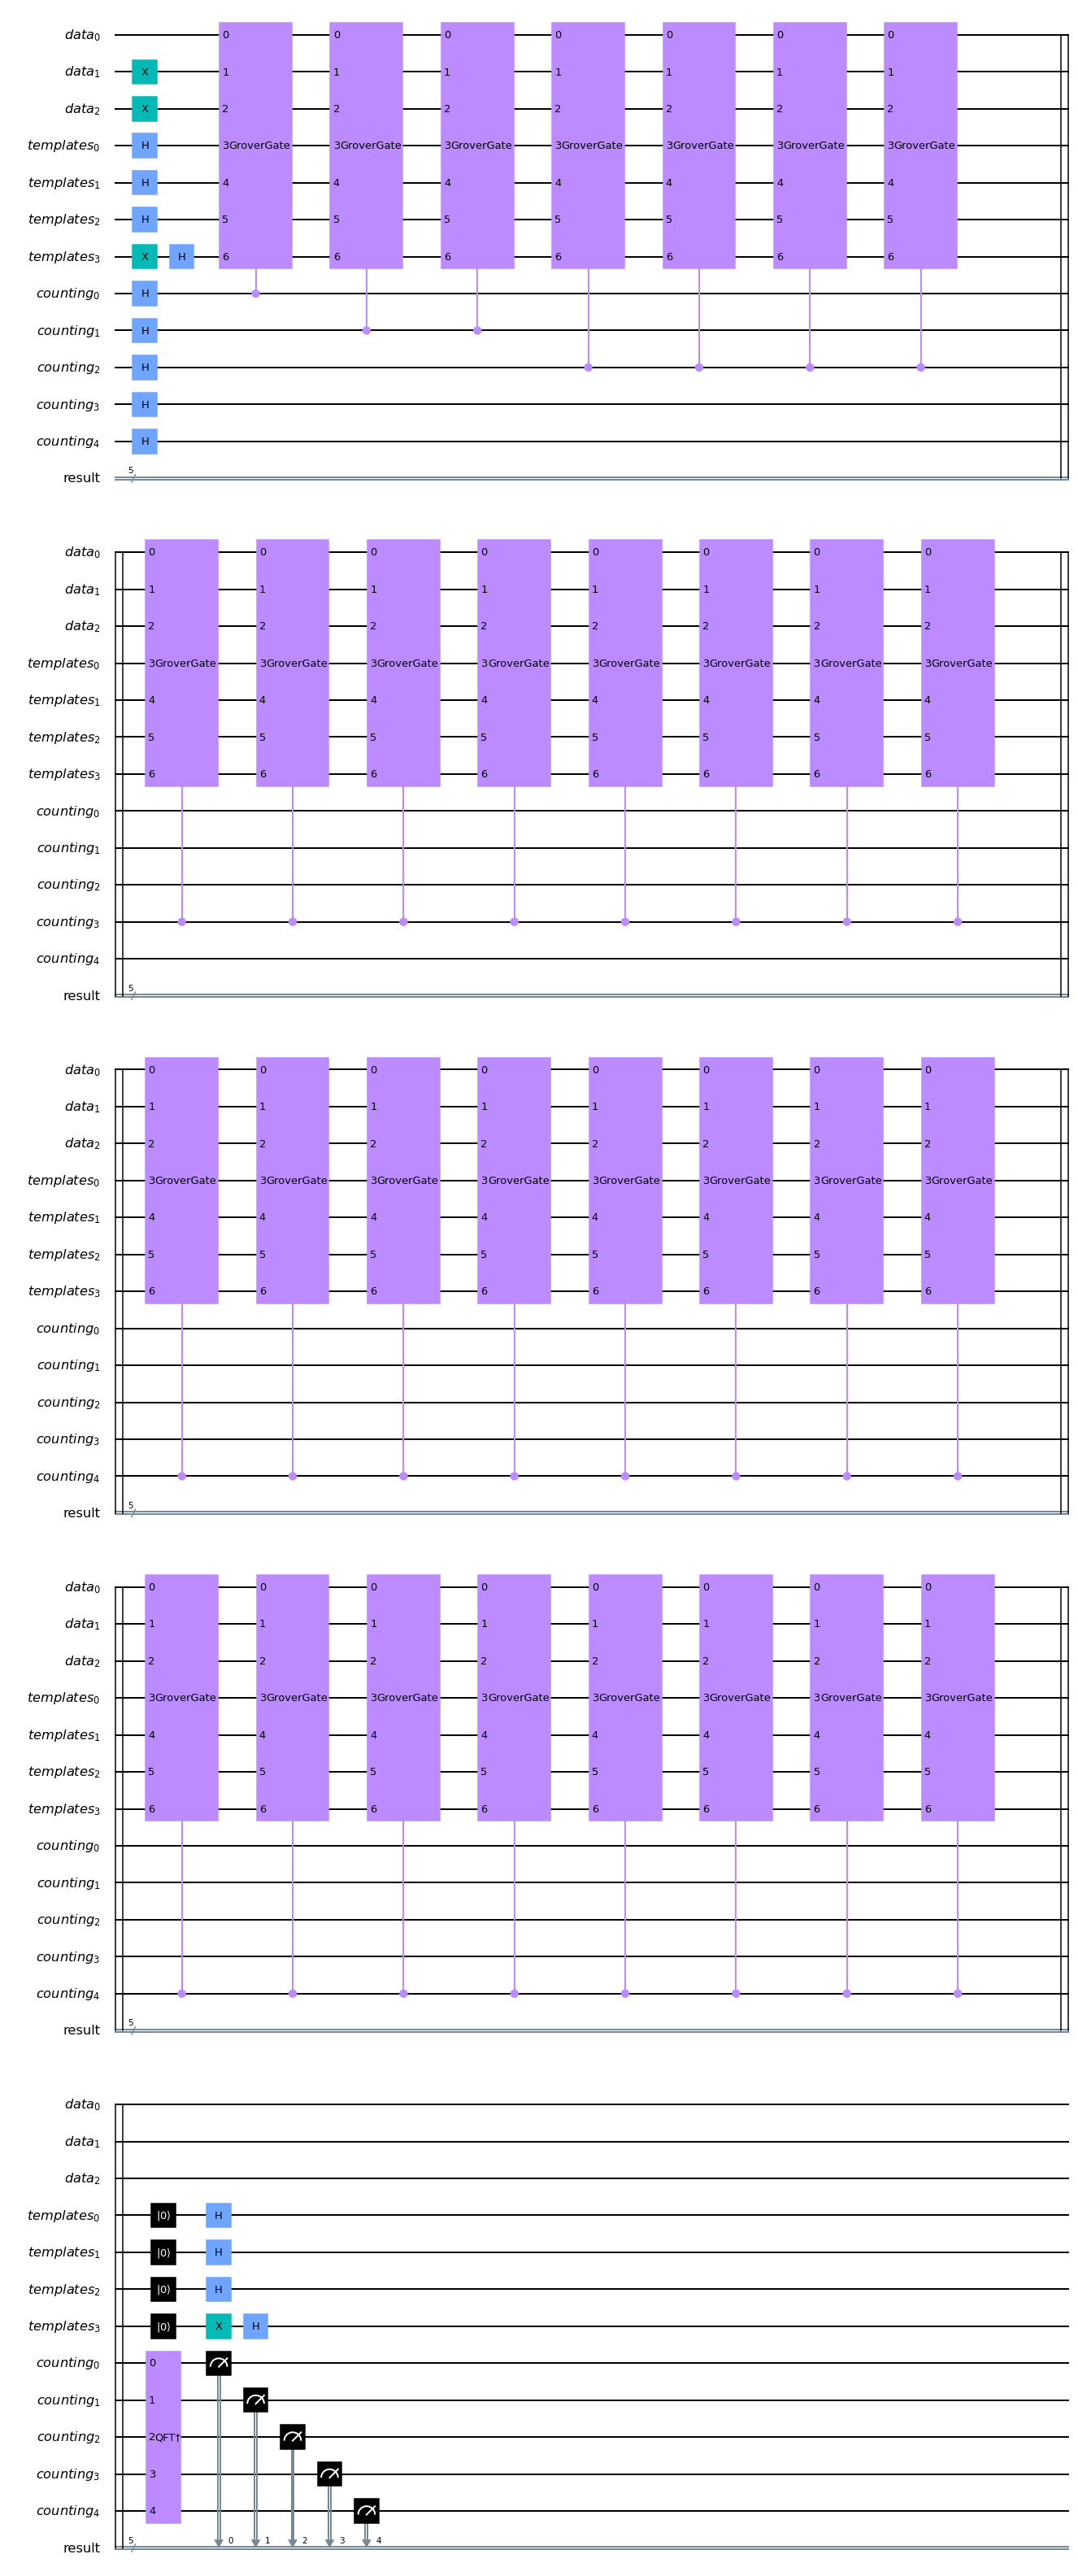

In [19]:
#reset the templates qubits
search_Circuit.reset(templates)
#search qubits are initialised to 0 while the ancilla is initialised to 1
search_Circuit.x(templates[n])
#Hadmard gate is applied to all qubits
search_Circuit.h(templates[0:a]) 
search_Circuit.draw(output="mpl")

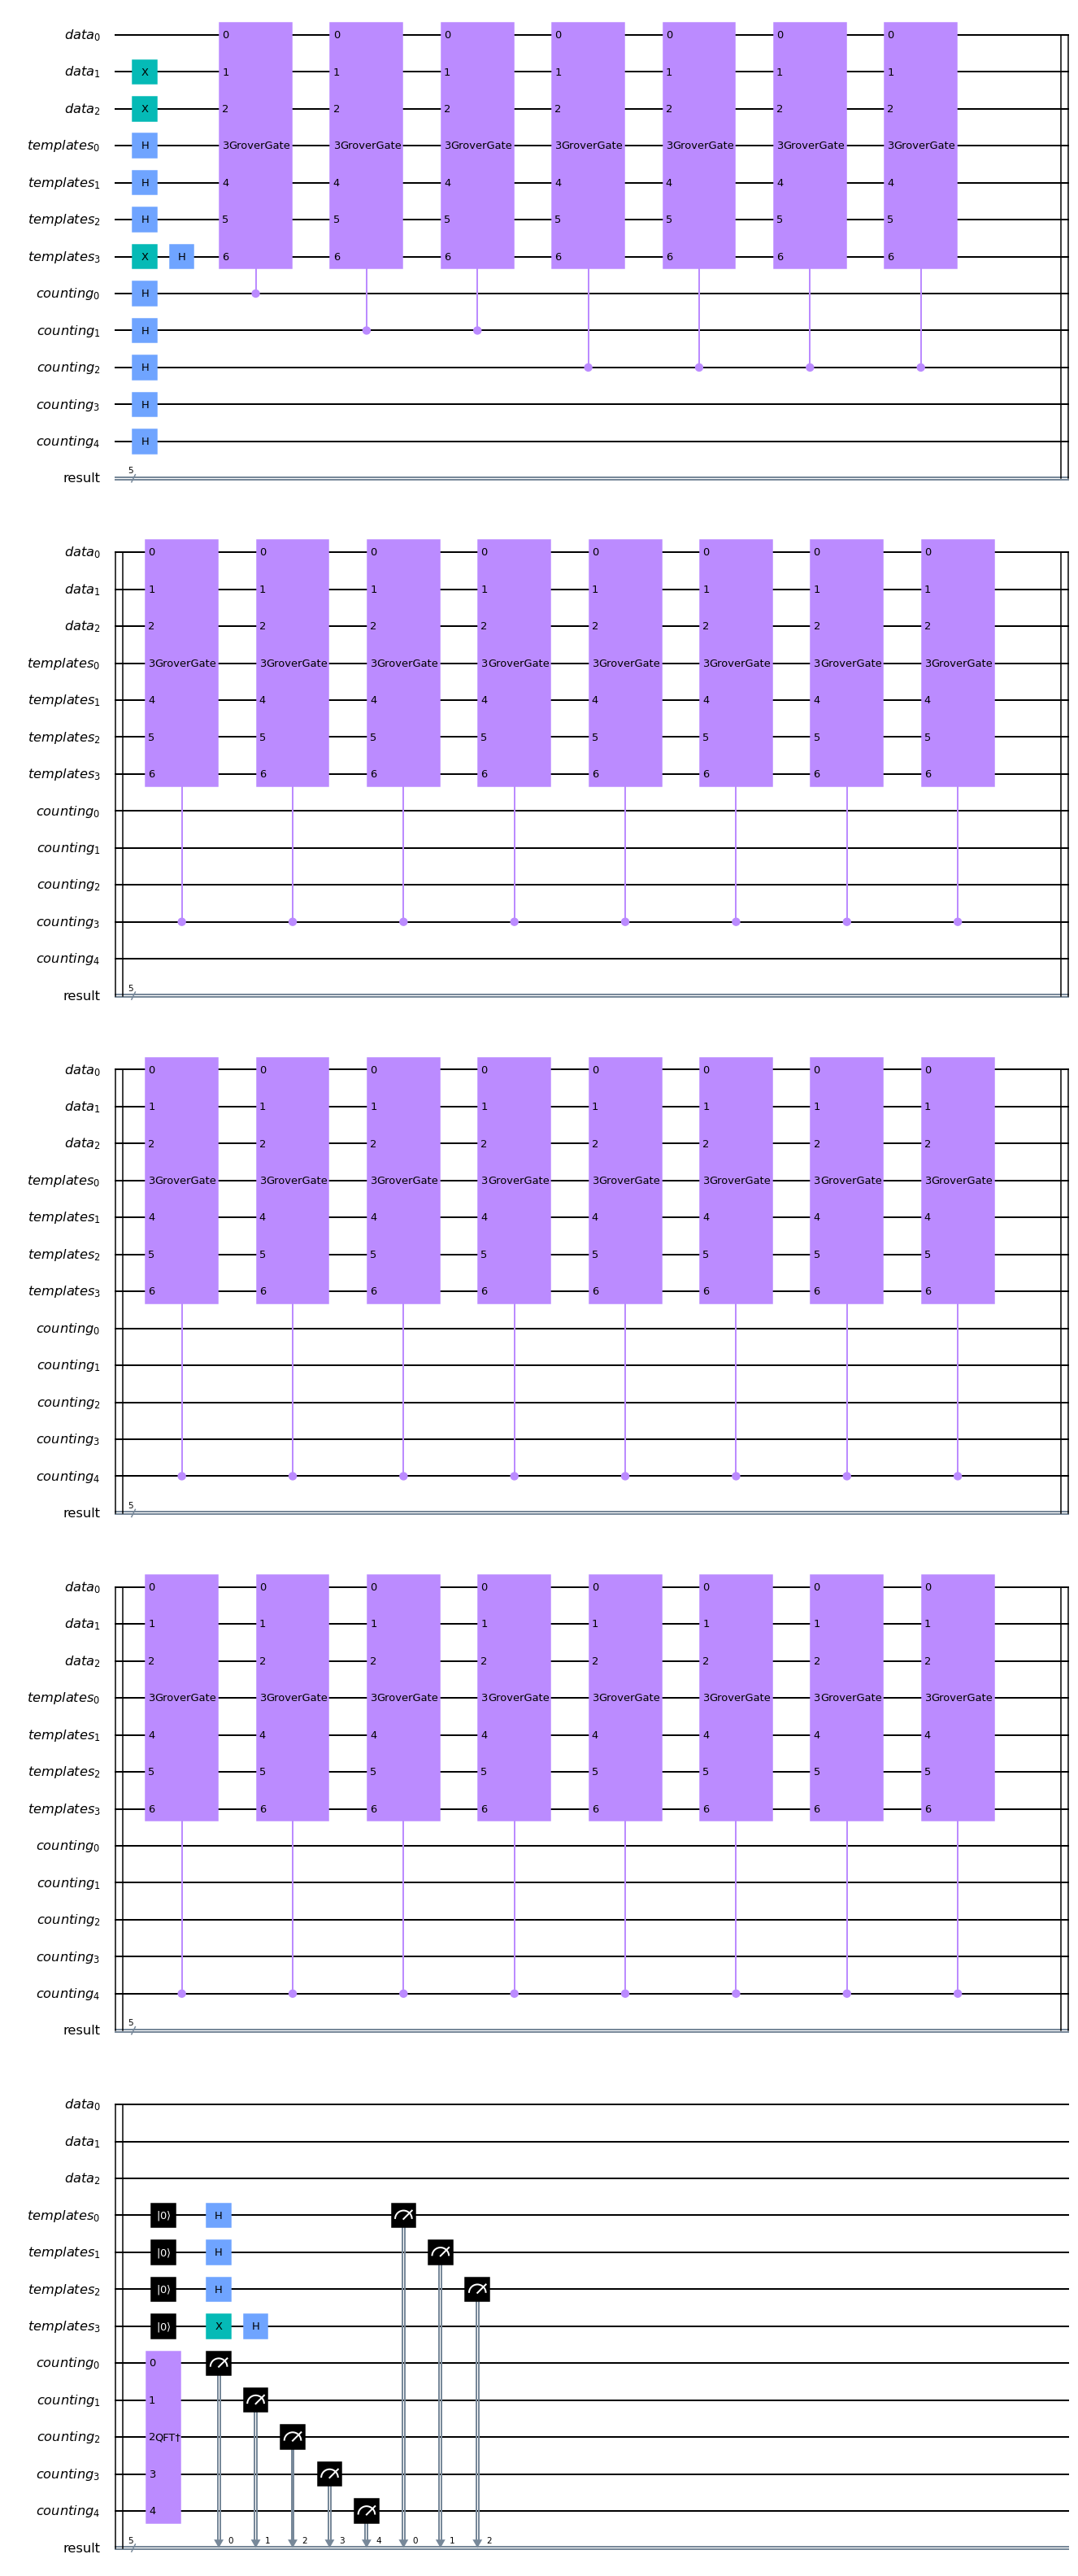

In [20]:
#measurement
for qubit in range(n):
    search_Circuit.measure(templates[qubit],result[qubit])
search_Circuit.draw(output='mpl')

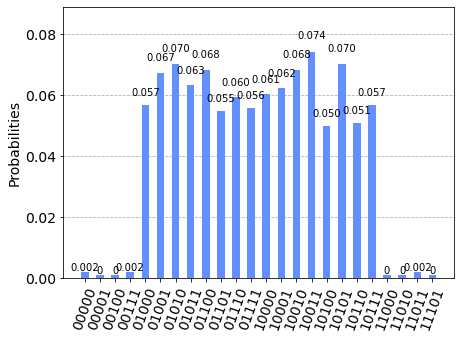

In [21]:
#experiment with the simulator
backend = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(search_Circuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

In [22]:
#quantum phase estimation

    